<a href="https://colab.research.google.com/github/PranavSingla122/Leaf-Classification/blob/main/leaf_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

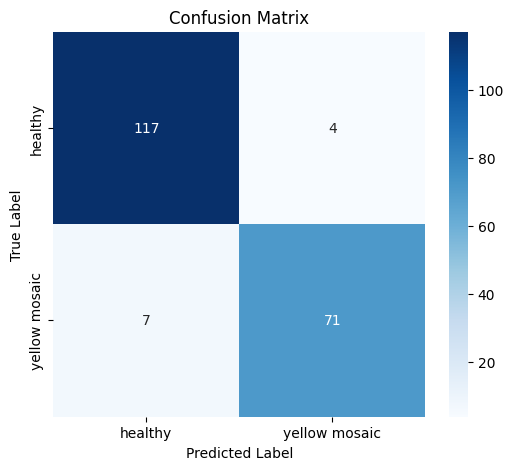

Classification Report:
                precision    recall  f1-score   support

      healthy       0.94      0.97      0.96       121
yellow mosaic       0.95      0.91      0.93        78

     accuracy                           0.94       199
    macro avg       0.95      0.94      0.94       199
 weighted avg       0.94      0.94      0.94       199



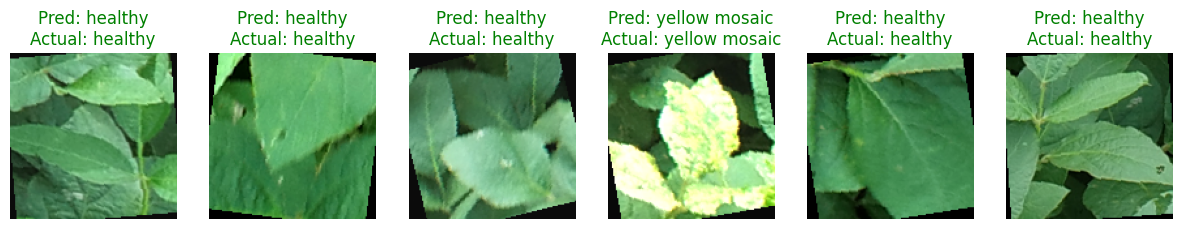

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from torchvision.utils import make_grid

# Load trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SoybeanClassifier().to(device)
model.load_state_dict(torch.load("soybean_classifier.pth"))
model.eval()

# Initialize lists to store losses and accuracy
train_losses = []
val_losses = []
val_accuracies = []

# Capture train loss, val loss, and accuracy (Assuming this is recorded in training loop)
for epoch in range(num_epochs):
    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_acc)



# Generate Confusion Matrix
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Compute Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.dataset.classes, yticklabels=train_dataset.dataset.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=train_dataset.dataset.classes))

# Visualize Sample Predictions
def show_predictions(model, test_loader, num_images=6):
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 4))
    for i in range(num_images):
        img = images[i].cpu().numpy().transpose(1, 2, 0)
        img = (img * 0.5) + 0.5  # Unnormalize
        axes[i].imshow(img)
        axes[i].set_title(f"Pred: {train_dataset.dataset.classes[preds[i]]}\nActual: {train_dataset.dataset.classes[labels[i]]}", color="green" if preds[i] == labels[i] else "red")
        axes[i].axis("off")

    plt.show()

show_predictions(model, test_loader)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load dataset
data_dir = "/content/drive/MyDrive/yellow mosaic (1)"
train_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define CNN model
class SoybeanClassifier(nn.Module):
    def __init__(self):
        super(SoybeanClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 2)  # 2 classes: Healthy, Yellow Mosaic

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SoybeanClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Save model
torch.save(model.state_dict(), "soybean_classifier.pth")
print("Model training complete and saved!")

Epoch [1/10], Loss: 0.6243
Epoch [2/10], Loss: 0.2440
Epoch [3/10], Loss: 0.1502
Epoch [4/10], Loss: 0.1249
Epoch [5/10], Loss: 0.1157
Epoch [6/10], Loss: 0.0808
Epoch [7/10], Loss: 0.0546
Epoch [8/10], Loss: 0.0834
Epoch [9/10], Loss: 0.0432
Epoch [10/10], Loss: 0.0247
Model training complete and saved!


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


data_dir = "/content/drive/MyDrive/yellow mosaic (1)"
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)


train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class SoybeanClassifier(nn.Module):
    def __init__(self):
        super(SoybeanClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 2)  # 2 classes: Healthy, Yellow Mosaic

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SoybeanClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%")

Epoch [1/10], Train Loss: 0.4777, Val Loss: 0.3261, Val Acc: 90.36%
Epoch [2/10], Train Loss: 0.1721, Val Loss: 0.2824, Val Acc: 92.89%
Epoch [3/10], Train Loss: 0.1515, Val Loss: 0.2462, Val Acc: 92.89%
Epoch [4/10], Train Loss: 0.1003, Val Loss: 0.2669, Val Acc: 92.39%
Epoch [5/10], Train Loss: 0.0744, Val Loss: 0.2657, Val Acc: 93.40%
Epoch [6/10], Train Loss: 0.0657, Val Loss: 0.3183, Val Acc: 90.86%
Epoch [7/10], Train Loss: 0.0458, Val Loss: 0.3780, Val Acc: 93.91%
Epoch [8/10], Train Loss: 0.0237, Val Loss: 0.3396, Val Acc: 93.40%
Epoch [9/10], Train Loss: 0.0321, Val Loss: 0.3733, Val Acc: 93.91%
Epoch [10/10], Train Loss: 0.0233, Val Loss: 0.4258, Val Acc: 93.40%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from torchvision import models

# Define transformations with augmentation
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load dataset
data_dir = "/content/drive/MyDrive/yellow mosaic (1)"
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Train-Val-Test Split
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load Pretrained Model (ResNet18)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)

# Modify the classifier layer for 2 classes (Healthy, Yellow Mosaic)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%")

# Save Fine-Tuned Model
torch.save(model.state_dict(), "finetuned_soybean_classifier.pth")
print("Fine-tuned model training complete and saved!")


Epoch [1/10], Train Loss: 0.3052, Val Loss: 0.2156, Val Acc: 93.91%
Epoch [2/10], Train Loss: 0.0583, Val Loss: 0.0809, Val Acc: 97.46%
Epoch [3/10], Train Loss: 0.0604, Val Loss: 0.0213, Val Acc: 98.98%
Epoch [4/10], Train Loss: 0.0376, Val Loss: 0.0380, Val Acc: 97.97%
Epoch [5/10], Train Loss: 0.0271, Val Loss: 0.0595, Val Acc: 98.48%
Epoch [6/10], Train Loss: 0.0170, Val Loss: 0.0827, Val Acc: 97.97%
Epoch [7/10], Train Loss: 0.0154, Val Loss: 0.0464, Val Acc: 98.98%
Epoch [8/10], Train Loss: 0.0104, Val Loss: 0.0330, Val Acc: 97.97%
Epoch [9/10], Train Loss: 0.0174, Val Loss: 0.1250, Val Acc: 97.97%
Epoch [10/10], Train Loss: 0.0087, Val Loss: 0.0327, Val Acc: 98.98%
Fine-tuned model training complete and saved!
